# Homework 5 : Taming text

In [424]:
%matplotlib inline
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

import numpy as np

import matplotlib.pyplot as plt
plt.style.use('ggplot')

from wordcloud import WordCloud
from PIL import Image

import nltk
import string

import pycountry

from tqdm import tqdm_notebook
import re

from ipywidgets import FloatProgress
from IPython.display import display

%load_ext autoreload

In [41]:
import sys       # avoid some errors under Windows..
reload(sys)  
sys.setdefaultencoding('utf8')

# Part 1 : Word Cloud

In this first part, we want to generate 2 wordclouds based on the content of Mrs Clinton's emails.<br/>
- The 1st wordcloud will be built on the original emails
- The 2nd one will be build on emails after they underwent a standard pre-processing pipeline.

## 0 - Load Data

In [42]:
path = 'hillary-clinton-emails/'
emails = pd.read_csv(path + "Emails.csv")
print(emails.shape)
emails.head()

,Id,DocNumber,MetadataSubject,MetadataTo,MetadataFrom,SenderPersonId,MetadataDateSent,MetadataDateReleased,MetadataPdfLink,MetadataCaseNumber,...,ExtractedTo,ExtractedFrom,ExtractedCc,ExtractedDateSent,ExtractedCaseNumber,ExtractedDocNumber,ExtractedDateReleased,ExtractedReleaseInPartOrFull,ExtractedBodyText,RawText
0,1,C05739545,WOW,H,"Sullivan, Jacob J",87.0,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739545...,F-2015-04841,...,NaN,"Sullivan, Jacob J <Sullivan11@state.gov>",NaN,"Wednesday, September 12, 2012 10:16 AM",F-2015-04841,C05739545,05/13/2015,RELEASE IN FULL,NaN,UNCLASSIFIED\r\nU.S. Department of State\r\nCa...
1,2,C05739546,H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...,H,NaN,NaN,2011-03-03T05:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH1/DOC_0C05739546...,F-2015-04841,...,NaN,NaN,NaN,NaN,F-2015-04841,C05739546,05/13/2015,RELEASE IN PART,"B6\r\nThursday, March 3, 2011 9:45 PM\r\nH: La...",UNCLASSIFIED\r\nU.S. Department of State\r\nCa...
2,3,C05739547,CHRIS STEVENS,;H,"Mills, Cheryl D",32.0,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739547...,F-2015-04841,...,B6,"Mills, Cheryl D <MillsCD@state.gov>","Abedin, Huma","Wednesday, September 12, 2012 11:52 AM",F-2015-04841,C05739547,05/14/2015,RELEASE IN PART,Thx,UNCLASSIFIED\r\nU.S. Department of State\r\nCa...
3,4,C05739550,CAIRO CONDEMNATION - FINAL,H,"Mills, Cheryl D",32.0,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739550...,F-2015-04841,...,NaN,"Mills, Cheryl D <MillsCD@state.gov>","Mitchell, Andrew B","Wednesday, September 12,2012 12:44 PM",F-2015-04841,C05739550,05/13/2015,RELEASE IN PART,NaN,UNCLASSIFIED\r\nU.S. Department of State\r\nCa...
4,5,C05739554,H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...,"Abedin, Huma",H,80.0,2011-03-11T05:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH1/DOC_0C05739554...,F-2015-04841,...,NaN,NaN,NaN,NaN,F-2015-04841,C05739554,05/13/2015,RELEASE IN PART,"H <hrod17@clintonemail.com>\r\nFriday, March 1...",B6\r\nUNCLASSIFIED\r\nU.S. Department of State...


First of all, let's briefly analyse our corpus :
- **Unit document** : An email
- **Corpus size** : 7945 documents
- **Language** : English
- **Character set** ; UTF-8

## 1 - Data Extraction

It seems that we are provided with either the raw text file or an "attempt at extracting the body" of the message. We compare them on one instance to understand them better.

In [64]:
emails["RawText"][1][:500] # 500 first char

'UNCLASSIFIED\r\nU.S. Department of State\r\nCase No. F-2015-04841\r\nDoc No. C05739546\r\nDate: 05/13/2015\r\nSTATE DEPT. - PRODUCED TO HOUSE SELECT BENGHAZI COMM.\r\nSUBJECT TO AGREEMENT ON SENSITIVE INFORMATION & REDACTIONS. NO FOIA WAIVER.\r\nRELEASE IN\r\nPART B6\r\nFrom:\r\nSent:\r\nTo:\r\nSubject:\r\nAttachments:\r\nB6\r\nThursday, March 3, 2011 9:45 PM\r\nH: Latest How Syria is aiding Qaddafi and more... Sid\r\nhrc memo syria aiding libya 030311.docx; hrc memo syria aiding libya 030311.docx\r\nCONFIDENTIAL\r\nMarch 3, 2011\r\nF'

In [73]:
emails["ExtractedSubject"][1], emails["ExtractedBodyText"][1]

(nan,
 'B6\r\nThursday, March 3, 2011 9:45 PM\r\nH: Latest How Syria is aiding Qaddafi and more... Sid\r\nhrc memo syria aiding libya 030311.docx; hrc memo syria aiding libya 030311.docx\r\nMarch 3, 2011\r\nFor: Hillary')

In [57]:
emails["RawText"].count(), emails["ExtractedBodyText"].count(), emails["ExtractedSubject"].count()

(7945, 6742, 6260)

<table>
<tr>
    <th>Raw Data</th>
    <th>Extracted Data</th>
</tr>
<tr>
    <td>We're assured to get all the all emails, and all the informations</td>
    <td>Some mails (1203) are missing, and concerning the remaining mails, we may have lost information</td>
</tr>
<tr>
    <td>We may process a same mail several time (and give it a bigger weight)</td>
    <td>Each mail is unique</td>
</tr>
<tr>
    <td>Contains a lot of mail's metadata, in which we are not interested in</td>
    <td>Only contains some dates and emails</td>
</tr>
</table>

The extracted data provided us we the information we are seeking for.<br/>
Even if we may loose information, we are not sure to implement a better extraction by ourselves.<br/>
Then, we chosen to keep the extracted data.

In [70]:
emails_subject = emails["ExtractedSubject"].dropna()
emails_body = emails["ExtractedBodyText"].dropna()

As we are insterested in the importance of each word in the corpus, we can concatenate it in a single string :

In [74]:
emails_subject = emails_subject.str.cat(sep=" ")
emails_body = emails_body.str.cat(sep=" ")
words = emails_body + emails_subject

## 2 - First wordcloud

In [117]:
# Defining the wordcloud generation
def generate_wordcloud(text):
    return WordCloud(background_color="white").generate(text)

Plot wordcloud for raw corpus

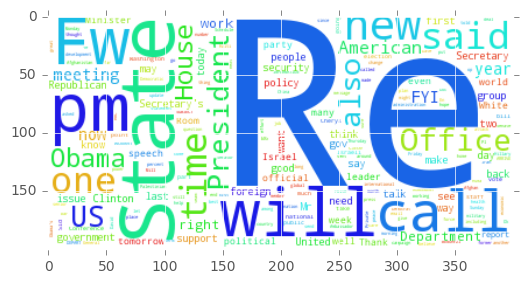

In [77]:
raw_wordcloud = generate_wordcloud(words)
img1 = plt.imshow(raw_wordcloud, origin='upper')
plt.show()

We observe a lot of words linked to the email-jargon : *"Re", "said", "Fw"*... <br/>
And some "useless" words like : *"year", "also", "time", "tomorrow", "today", "new"*..<br/>
Let's see what we can achieve using a pre-processing pipeline.

## 3 - Pre-processing pipeline

We apply a standard pre-processing pipeline to the corpus : Tokenization, Normalization, Stop-words removal and Lemmatization.

- **Tokenization and Normalization**

**Tokenization** : Split the string-corpus into a list of tokens
**Normalization** : Try to find a unity within word, and remove noisy characters
    - Email adress removal : We are not interested in the mail adress but in the mail content
    - Replace apostrophes by whitespaces
    - Put tokens into lowercase : We can loose some information (ex: "Windows" => "windows") but it enables to group identical words.
    - Remove ponctuation-words 
    - Remove ponctuation within words : (ex: "un-discriminatory" => "undiscriminatory")
    - Remove digits : Digits can be useful, especially for dates (imagine a conversation about the 7/01/2015 in France), but in this case, digits are mostly used to mention the email's date (in which we are not interested)

In [173]:
def tokenization_normalization(txt):
    
    mail_adress = re.compile(r"([^\s]+?)@(.+?)\.([^\s]+)")
    txt = mail_adress.sub("", txt) # Remove mail adress

    txt = txt.replace('\'', ' ')
    
    tokens = nltk.word_tokenize(txt) # Tokenization (split on spaces + ponctuation)
    
    punctuations = list(string.punctuation)
    tokenized = [token.lower() for token in tokens if token not in punctuations] # Lowercase + remove ponctuation
    
    digits = re.compile(r'[-.?!,/\*":;()<>|0-9]') # Remove punctuation within words and digits
    tokenized_nodigits = [digits.sub("", token) for token in tokenized]  
    
    token_normalized = list(filter(None, tokenized_nodigits)) # remove empty strings
    
    return token_normalized

- **Stop-word removal**

We first build a stop-list, composed of irrelevant words (often very common words) :

In [206]:
def get_stop_words():
    stop_list = nltk.corpus.stopwords.words('english') # Pre-established stop-list
    
    days = ["monday", "tuesday", "wednesday", "thursday", "friday", "saturday", "sunday"]
    months = ["january", "february", "march", "april", "may", "june", "july", "august", "september", "october", "november", 
              "december"]
    time = ['am', 'pm', "year", "month", "week", "day", "hour", "minute", "sec", "today", "tomorrow", "yesterday"]
    mail_voc = ['unclassified', 'send', 'date', 're', "doc", "message", "b6", "original", "case", "us", "from", "sent", "to", 
                "subject", "attachments", "cc", "fw", "nt"]
    recurrent_words = ["state", "department", "call", "new", "gov", "release", "part", "in", "no", "gov", "time","say", 
                       "stategov", "would", "say", "also", "go", "want", "make", "know"]
    numbers = ["one", "two", "three", "four", "five", "six", "seven", "eight", "nine", "ten", "eleven", "twelve"]
    add_stopwords =  days + months + time + mail_voc + recurrent_words + numbers
    
    return stop_list + add_stopwords

Then we remove them from tokens.

In [162]:
def stopword_removal(tokens):
    stop_list = get_stop_words()
    filtered = [word for word in tokens if word not in stop_list] # Remove stop-words
    
    return filtered

- **Lemmatization**

Lemmatization enables to build equivalence classes between similarly constructed tokens, which are likely to have similar semantic sense. <br/>
It identifies a canonical representative for a set of related word forms.<br/>
However, this method isn't infallible : 
    - some similar words can be attributed different representative,
    - some different words (in terms of semantic sense) can be attributed a same representative.

In [163]:
def lemmatization(tokens):
    wnl = nltk.stem.wordnet.WordNetLemmatizer() # Generate lemmatizer
    lemmatized = [wnl.lemmatize(i,j[0].lower()) if j[0].lower() in ['a','n','v'] 
                  else wnl.lemmatize(i) 
                  for i,j in nltk.pos_tag(tokens)] # i = word, j = grammatical class
    return lemmatized

- ** Finally process data **

In [165]:
def preprocessing(words, verbose=False):
    
    words = words.encode('ascii', errors='ignore') # avoid some errors under windows..
    
    # Tokenization - Normalization
    if verbose:
        print("Tokenization - Normalization...")
    token_normalized = tokenization_normalization(words)
    
    # Stopword removal
    if verbose:
        print("Stopword removal...")
    filtered = stopword_removal(token_normalized)
    
    # Lemmatisation
    if verbose:
        print("Lemmatization...")
    lemmatized = lemmatization(filtered)
 
    # We remove stopwords a second time in order to remove tokens which have been lemmatized as stopwords
    filtered_2 = stopword_removal(lemmatized)
    final_processing = [word for word in filtered_2 if len(word)!=1] # Remove single-letter words
    
    return final_processing

In [207]:
## WARNING : SUPER LONG (you can directly load it in the cell bellow)
processed_corpus = preprocessing(words, verbose=True)

In [208]:
# Save file
corpus_file = open("processed_corpus.txt", 'w')
for token in processed_corpus:
    corpus_file.write("%s\n" % token)
corpus_file.close()

In [ ]:
processed_corpus = [line.rstrip('\n') for line in open('processed_corpus.txt')]

## 4 - Second Wordcloud

Let's build our second word cloud, based on the pre-processed corpus :

In [204]:
def generate_wordcloud2(text):
    mask = np.array(Image.open("onlymask.jpg"))
    return WordCloud(background_color="white", mask=mask).generate(text)

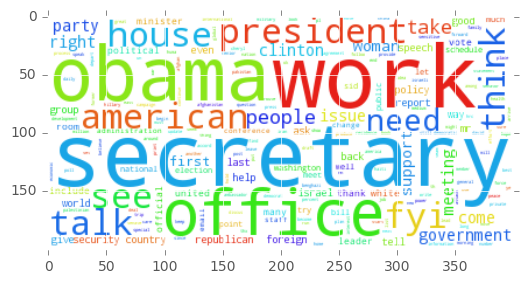

In [209]:
corpus_str = ' '.join(processed_corpus) # Concatenate Tokens
preprocessed_wordcloud = generate_wordcloud(corpus_str)
img2 = plt.imshow(preprocessed_wordcloud)
plt.show()

We now get a set of more representative words. Emails-jargon has been replaced by political terms, like :<br/>
*"obama", "republican", "israel", "woman", "party", "government", "meeting", "security", "country", "minister", "president", "work"...*

We can also plot the frequence of the most employed words :

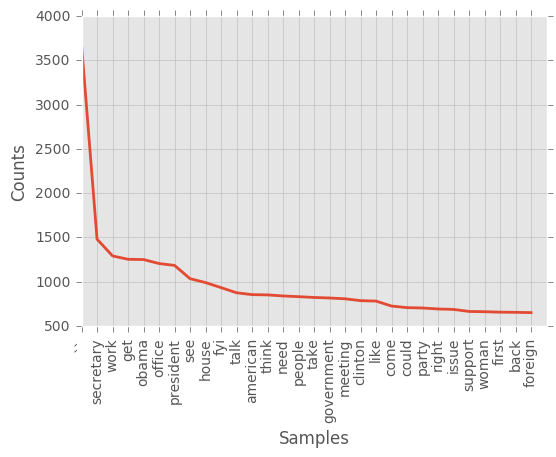

In [210]:
fd = nltk.FreqDist(processed_corpus)
fd.plot(30, cumulative=False)

- Extra : What about the Fitz's law?

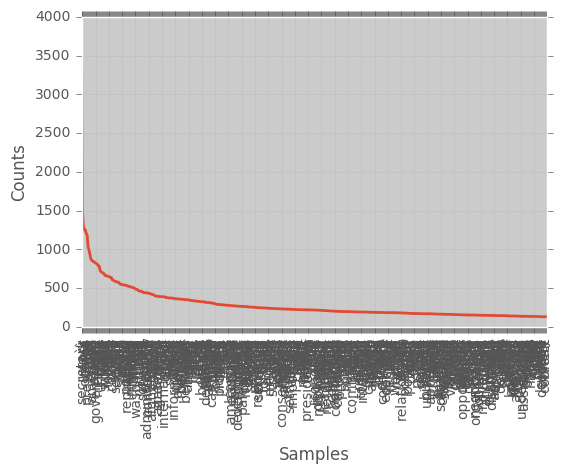

In [211]:
fd = nltk.FreqDist(processed_corpus)
fd.plot(500, cumulative=False)

The Zipf's law seems to be verified !

# Part 2 : Sentiment analysis by country

In this second part, we will summarize the perception of the different countries following this process :
- Find all the mentions of world countries in each mail
- Perform sentiment analysis on every mail (using different methods)
- Conclude about the sentiment associated to each country (averaging their scores)

### Once again : Raw data or Extracted Data?

The first question that arises is : should we work on raw data or extracted data?

<table>
<tr>
    <th>Raw Data</th>
    <th>Extracted Data</th>
</tr>
<tr>
    <td>As we have access to the whole conversation, we are more likely to find what country is the conversation about. But it has also drawbacks : the conversation may change of subject and emotion. Then, sentiment analysis and its association to one particular country could be biased.</td>
    <td>We may not find any country reference in a lot of emails (even if the mail is speaking about a country, in answer to another email. However, we may be more accurate in our sentiment analysis, and in our association with a country</td>
</tr>
<tr>
    <td>We may process a same mail several time (and give it a bigger weight)</td>
    <td>Each mail is unique</td>
</tr>
<tr>
    <td>Contains a lot of mail's metadata, which include the country of the sender or receiver. Now, we are interested in the countries that are mentionned in mails, and they could be drown by the metadata.</td>
    <td>Only the countries mentionned in mails appear</td>
</tr>
</table>

So, again, we choose to work on the extracted data.

### Emails Processing

Let's build our new dataset : we want for each mail the subject and the body concatenated :

In [356]:
extracted_data = emails[["ExtractedSubject", "ExtractedBodyText"]]
extracted_data = extracted_data.dropna(how="all") # Remove mails without content (no subject, no body)
extracted_data = extracted_data.fillna('') # Replace NaN values by '' in order to concatenate body and subject
extracted_mails = extracted_data["ExtractedSubject"] + extracted_data["ExtractedBodyText"]

Let's apply it a micro pre-processing pipeline (it is not necessary to apply the full pre-processing, we are only interested in countries and sentiments) :

In [355]:
def get_reduced_stop_list():
    days = ["monday", "tuesday", "wednesday", "thursday", "friday", "saturday", "sunday"]
    months = ["january", "february", "march", "april", "may", "june", "july", "august", "september", "october", "november", 
              "december"]
    time = ['am', 'pm', "year", "month", "week", "day", "hour", "minute", "sec", "today", "tomorrow", "yesterday"]
    mail_voc = ['unclassified', 'send', 'date', 're', "doc", "message", "b6", "original", "case", "us", "from", "sent", "to", 
                "subject", "attachments", "cc", "fw", "nt", "docx"]
    numbers = ["one", "two", "three", "four", "five", "six", "seven", "eight", "nine", "ten", "eleven", "twelve"]
    return days + months + time + mail_voc + numbers

In [352]:
def reduced_preprocessing(txt):
    
    txt = txt.lower() # Lowercase
    
    mail_adress = re.compile(r"([^\s]+?)@(.+?)\.([^\s]+)")
    txt = mail_adress.sub("", txt) # Remove mail adress (can give information on the country)
    
    txt = re.sub('\s+', ' ', txt) # Remove \n \t \r etc
    
    txt = txt.replace('-', ' ') # Replace dashes by white-space (better to recognize the country)
    txt = txt.replace("'", ' ') # Replace apostrophe by white-space
    
    digits = re.compile(r'[<>,:|0-9]') # Remove some punctuation within words and digits
    txt = digits.sub("", txt)
    
    stop_list = get_reduced_stop_list() # Remove stop-words (essentially linked to mail's noise)
    for stop_word in stop_list:
        regex_stop = re.compile(r'(^|\s)'+stop_word+'(\s|$)')
        txt = regex_stop.sub(" ", txt)
    
    return txt

In [357]:
extracted_mails = extracted_mails.apply(lambda x: reduced_preprocessing(x))

### Get country dataframe

The pycountry utility gives us 4 possible denominations; we gather them into a single dataframe :

In [422]:
def get_country_df():
    countries = pd.DataFrame(columns=['alpha_2', 'alpha_3', 'name', 'official_name'])
    
    for idx, country in enumerate(list(pycountry.countries)):
        try:
            a3 = country.alpha3 
        except (AttributeError): # alpha_3 is sometimes missing
            a3 = np.nan
        try:
            offi = country.official_name
        except (AttributeError): # official_name is sometimes missing
            offi = np.nan
        countries.loc[idx] = [country.alpha2, a3, country.name, offi]
        
    countries = countries.apply(lambda x: x.str.lower())  # lowercase, to match with the mails
    
    return countries

In [423]:
countries = get_country_df()
countries.head()

,alpha_2,alpha_3,name,official_name
0,af,afg,afghanistan,islamic republic of afghanistan
1,ax,ala,åland islands,NaN
2,al,alb,albania,republic of albania
3,dz,dza,algeria,people's democratic republic of algeria
4,as,asm,american samoa,NaN


### Get emails country references

In [425]:
def get_country_references(mails, countries):
    references = []
    
    f = FloatProgress(min=0, max=len(mails))
    display(f)
    
    for idx_mail in extracted_mails.index:
        for idx_country in countries.index:                   # search for all countries
            for country_denomination in countries.columns:    # search for all denominations
                
                if not pd.isnull(countries.loc[idx_country][country_denomination]):
                    regex = re.compile(r'(^|\s)'+countries.loc[idx_country][country_denomination]+'(\s|$)')

                    if regex.search(extracted_mails[idx_mail]) is not None:
                        references.append([idx_country, idx_mail])
                        break
    
        f.value += 1
    
    return pd.DataFrame(references, columns=['idx_mail', "idx_country"])  

In [ ]:
# Takes a LOT OF TIME
country_references = get_country_references(extracted_mails, countries)

### Sentiment analysis

The *nltk.sentiment.util* module gives us several choices of methods to perform sentiment analysis. We chose two of them :
- **Liu and Hu opinion lexicon** : <br/>
*Counts the number of positive, negative and neutral words in the sentence and classifies it depending on which polarity is more represented.*
- **Vader approach** :<br/>
*Output polarity scores for a text using Vader approach.*

In [ ]:
from nltk.sentiment.util import *

In [ ]:
liu_and_hu = [demo_liu_hu_lexicon(mail) for mail in extracted_mails]

In [ ]:
vader = [demo_vader_instance(mail) for mail in extracted_mails]